In [34]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [35]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
#%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [36]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [37]:
train_data = extract_data('Data/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('Data/t10k-images-idx3-ubyte.gz', 10000)

In [38]:
#!pip install scikit-image

from skimage import io

In [39]:
#pip install -U scikit-image
import skimage

In [40]:
print(train_data[0].shape)

(28, 28)


In [41]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


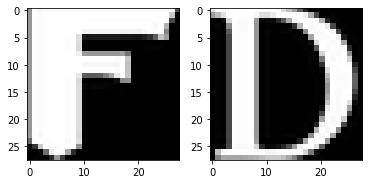

In [42]:
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
plt.imshow(curr_img, cmap='gray')


In [43]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [44]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [45]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [46]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [47]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [48]:
batch_size = 128
epochs = 1
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [49]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [50]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [51]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         1475

In [52]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 95s 2ms/step - loss: 0.0349 - val_loss: 0.0146


In [53]:
noise_image = test_data[0]

In [54]:
row,col,ch= noise_image.shape
mean = 0
var = 0.3
sigma = var**0.7
gauss = np.random.normal(mean,sigma,(row,col,ch))
gauss = gauss.reshape(row,col,ch)
noisy = noise_image + gauss


In [55]:
noisy = noisy.reshape(-1, 28,28, 1)

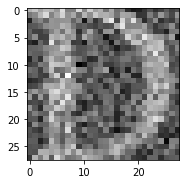

In [56]:
plt.subplot(121)
curr_img = np.reshape(noisy, (28,28))
plt.imshow(curr_img, cmap='gray')


In [57]:
predicted = autoencoder.predict(noisy)

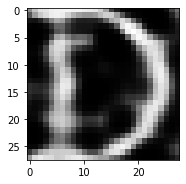

In [58]:
plt.subplot(121)
curr_img = np.reshape(predicted, (28,28))
plt.imshow(curr_img, cmap='gray')